In [13]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal as mvn

%matplotlib inline

# Load and visualize the image

In [84]:
img = cv2.imread('banana.png')

box = [200, 520, 280, 370]
x1, x2, y1, y2 = box

in_box = img[y1: y2, x1: x2, :]

Display the entire image with a bounding box

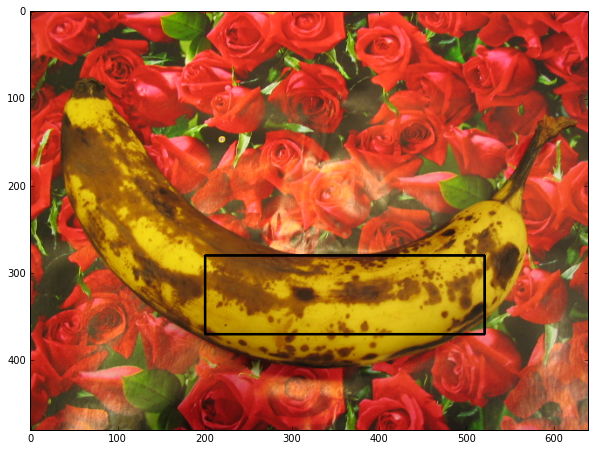

In [83]:
img_with_box = img.copy()
img_with_box = cv2.rectangle(img_with_box, (x1, y1), (x2, y2), 1, 2)

plt.figure(figsize=[10, 10])
img_plt = cv2.cvtColor(img_with_box, cv2.COLOR_BGR2RGB)
plt.imshow(img_plt)
plt.show()

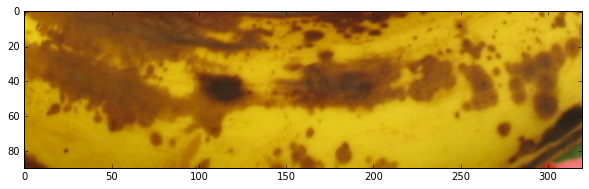

In [29]:
plt.figure(figsize=[10, 10])
img_plt = cv2.cvtColor(in_box, cv2.COLOR_BGR2RGB)
plt.imshow(img_plt)
plt.show()

In [30]:
def fit_gmm(data, K=5, verbose=False):
    def likelihood(means, covariances, mixing_proportions):
        # Compute data log-likelihood for the given GMM parametrization
        densities = np.array([mvn.pdf(data, means[k], covariances[k]) for k in range(K)])
        unnormalized_responsibilities = densities * mixing_proportions
        return np.log(unnormalized_responsibilities.sum(axis=0)).sum()

    data = data.reshape(-1, data.shape[-1])

    N = data.shape[0]
    D = data.shape[1] # Dimension of the data points
    
    # Initialize the variables that are to be learned
    covariances = np.array([100 * np.eye(D) for k in range(K)]) # Covariance matrices
    mixing_proportions = np.ones([K, 1]) / K # Mixing propotions
    responsibilities = np.zeros([N, K])
    
    # Choose the initial centroids using k-means clustering
    kmeans = KMeans(n_clusters=K)
    kmeans = kmeans.fit(data)
    means = kmeans.cluster_centers_
    
    old_likelihood = likelihood(means, covariances, mixing_proportions)
    
    if verbose:
        print("Likelihood after intialization: {0:.2f}".format(old_likelihood))
        
    # Iterate until convergence
    it = 0
    converged = False
    while not converged:
        it += 1
        old_likelihood = likelihood(means, covariances, mixing_proportions)

        # Compute the responsibilities
        densities = np.array([mvn.pdf(data, means[k], covariances[k]) for k in range(K)])
        responsibilities = densities * mixing_proportions
        responsibilities = (responsibilities / responsibilities.sum(axis=0)).T

        # Update the distribution parameters
        resp_sums = responsibilities.sum(axis=0)
        means = responsibilities.T.dot(data)
        for k in range(K):
            means[k] /= resp_sums[k]
            covariances[k] = np.zeros(D)
            for n in range(N):
                centered = data[n, :] - means[k]
                covariances[k] += responsibilities[n, k] * np.outer(centered, centered)
            covariances[k] /= resp_sums[k]
            covariances[k] += 0.1 * np.eye(D) # To prevent singular matrices
        mixing_proportions = np.reshape(resp_sums / N, [K, 1])

        # Check for convergence
        new_likelihood = likelihood(means, covariances, mixing_proportions)
        delta = new_likelihood - old_likelihood
        converged = delta < np.abs(new_likelihood) * 1e-4
        if verbose:
            print("Iteration {0}, likelihood = {1:.2f}, delta = {2:.2f}".format(it, new_likelihood, delta))
            
    return (means, covariances, mixing_proportions)

In [90]:
def show_segmented(img, means, covariancesiances, mixing_proportions, threshold=1e-7):
    K = means.shape[0]
    flat_img = img.reshape([-1, img.shape[-1]])
    probas = np.array([mixing_proportions[k] * mvn.pdf(flat_img, means[k], covariances[k]) for k in range(K)]).T
    probas = probas.sum(axis=1)
    plt.figure(figsize=[10, 10])
    plt.imshow((probas > threshold).reshape(img.shape[:2]))
    plt.show()

# GMM trained inside the box

In [81]:
means, covariances, mixing_proportions = fit_gmm(in_box, K=5, verbose=True)

Likelihood after intialization: -364270.83
Iteration 1, likelihood = -339269.20, delta = 25001.63
Iteration 2, likelihood = -337294.58, delta = 1974.62
Iteration 3, likelihood = -336685.15, delta = 609.43
Iteration 4, likelihood = -336442.18, delta = 242.97
Iteration 5, likelihood = -336247.04, delta = 195.14
Iteration 6, likelihood = -336054.14, delta = 192.90
Iteration 7, likelihood = -335640.30, delta = 413.84
Iteration 8, likelihood = -332322.05, delta = 3318.25
Iteration 9, likelihood = -331542.43, delta = 779.62
Iteration 10, likelihood = -331405.14, delta = 137.30
Iteration 11, likelihood = -331319.94, delta = 85.20
Iteration 12, likelihood = -331253.66, delta = 66.28
Iteration 13, likelihood = -331195.66, delta = 58.01
Iteration 14, likelihood = -331141.91, delta = 53.75
Iteration 15, likelihood = -331091.66, delta = 50.25
Iteration 16, likelihood = -331045.42, delta = 46.24
Iteration 17, likelihood = -331003.57, delta = 41.85
Iteration 18, likelihood = -330965.89, delta = 37.6

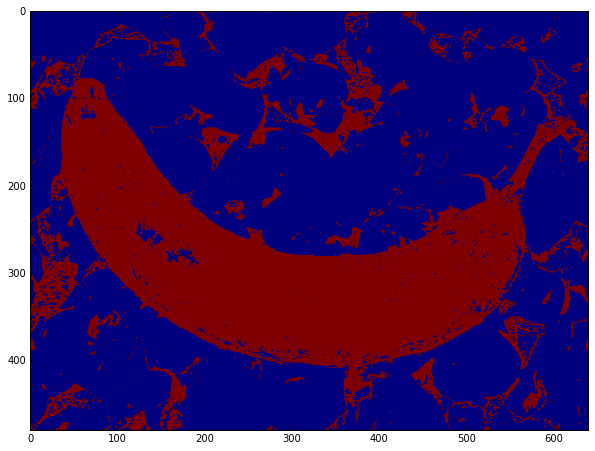

In [82]:
show_segmented(img, means, covariances, mixing_proportions)

# GMM trained outside the box

Really ugly way to select all the pixels that are not inside the bounding box

In [85]:
xrange = set(range(x1, x2))
yrange = set(range(y1, y2))

outside_box = []
for (x, y), val in np.ndenumerate(img[:, :, 0]):
    if x not in xrange and y not in yrange:
        outside_box.append(img[x, y, :])
        
outside_box = np.array(outside_box)

In [86]:
means, covariances, mixing_proportions = fit_gmm(outside_box, K=5, verbose=True)

Likelihood after intialization: -1828118.35
Iteration 1, likelihood = -1499186.19, delta = 328932.16
Iteration 2, likelihood = -1491937.18, delta = 7249.01
Iteration 3, likelihood = -1487166.47, delta = 4770.72
Iteration 4, likelihood = -1483348.41, delta = 3818.06
Iteration 5, likelihood = -1480288.26, delta = 3060.15
Iteration 6, likelihood = -1477756.45, delta = 2531.81
Iteration 7, likelihood = -1475357.81, delta = 2398.64
Iteration 8, likelihood = -1472853.75, delta = 2504.06
Iteration 9, likelihood = -1471071.96, delta = 1781.79
Iteration 10, likelihood = -1469821.93, delta = 1250.03
Iteration 11, likelihood = -1468838.41, delta = 983.52
Iteration 12, likelihood = -1468065.45, delta = 772.96
Iteration 13, likelihood = -1467462.06, delta = 603.38
Iteration 14, likelihood = -1466983.84, delta = 478.23
Iteration 15, likelihood = -1466593.15, delta = 390.69
Iteration 16, likelihood = -1466262.39, delta = 330.75
Iteration 17, likelihood = -1465970.54, delta = 291.85
Iteration 18, like

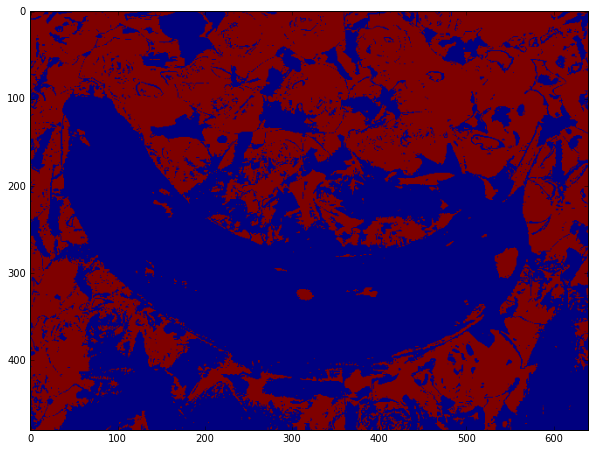

In [89]:
show_segmented(img, means, covariances, mixing_proportions, threshold=1e-6)